In [1]:
import numpy as np
import pandas as pd
import optuna
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

In [2]:
def create_n_dimensional_meshgrid(n_dimensions, num_points=10, start=0, end=1):
    """
    Create an n-dimensional meshgrid.
    
    Parameters:
    - n_dimensions: int, number of dimensions
    - num_points: int, number of points along each dimension (default: 40)
    - start: float, start value for linspace (default: 0)
    - end: float, end value for linspace (default: 1)
    
    Returns:
    - X_viz: numpy array, shape (num_points**n_dimensions, n_dimensions)
    """
    # Create linspace for each dimension
    x = np.linspace(start, end, num_points)
    
    # Create meshgrid
    X = np.meshgrid(*[x for _ in range(n_dimensions)])
    
    # Stack and reshape the meshgrid
    X_viz = np.column_stack([X[i].ravel() for i in range(n_dimensions)])
    
    return X_viz

# Example usage:
n_dim = 4  # Change this to any number of dimensions
X_viz = create_n_dimensional_meshgrid(n_dim)

print(f"Shape of X_viz: {X_viz.shape}")


def create_n_dimensional_meshgrid_v2(initial_coords, buffer, num_points=10):
    """
    Create an n-dimensional meshgrid centered around initial coordinates with a buffer.
    
    Parameters:
    - initial_coords: list or numpy array, initial coordinates
    - buffer: float, buffer around each coordinate
    - num_points: int, number of points along each dimension (default: 10)
    
    Returns:
    - X_viz: numpy array, shape (num_points**n_dimensions, n_dimensions)
    """
    # Ensure initial_coords is a numpy array
    initial_coords = np.array(initial_coords)
    n_dimensions = len(initial_coords)
    
    # Create linspace for each dimension
    X = []
    for coord in initial_coords:
        start = max(0, coord - buffer)  # Ensure non-negative
        end = min(1, coord + buffer)    # Ensure not exceeding 1
        X.append(np.linspace(start, end, num_points))
    
    # Create meshgrid
    meshgrid = np.meshgrid(*X)
    
    # Stack and reshape the meshgrid
    X_viz = np.column_stack([grid.ravel() for grid in meshgrid])
    
    return X_viz

# Example usage:
initial_point = [0.5, 0.3, 0.7, 0.4]  # Example initial point
buffer = 0.2
X_viz = create_n_dimensional_meshgrid_v2(initial_point, buffer)
print(f"Shape of X_viz: {X_viz.shape}")
print(f"Range for each dimension:")
for i in range(len(initial_point)):
    print(f"Dimension {i+1}: {X_viz[:, i].min():.2f} to {X_viz[:, i].max():.2f}")


def format_results(label, best_numbers):
    #Formats weekly submission form 
    print(label)
    print(np.array2string(np.array(best_numbers), precision=6, separator='-', floatmode='fixed', formatter={'float': '{:0.6f}'.format}))

Shape of X_viz: (10000, 4)
Shape of X_viz: (10000, 4)
Range for each dimension:
Dimension 1: 0.30 to 0.70
Dimension 2: 0.10 to 0.50
Dimension 3: 0.50 to 0.90
Dimension 4: 0.20 to 0.60


In [3]:
def load_and_process_data(function_num=1, num_weeks=1):
    # Load initial data
    def load_data(i):
        X = np.load(f'initial_data/function_{i}/initial_inputs.npy')
        y = np.load(f'initial_data/function_{i}/initial_outputs.npy')
        return X, y
    
    X, y = load_data(function_num)
    dimension = X.shape[1]
    print(f"Shape of initial X: {X.shape}")
    print(f"Shape of initial y: {y.shape}")
    
    # Load and combine weekly data
    for week in range(1, num_weeks + 1):
        results_dir = f'results/week{week}'
        X_week = np.load(f'{results_dir}/f{function_num}.npy')
        y_week = np.load(f'{results_dir}/f_y{function_num}.npy')
        
        # Combine data
        X = np.vstack((X, X_week))
        y = np.concatenate((y, y_week))
        
        print(f"After week {week}:")
        print(f"Shape of X: {X.shape}")
        print(f"Shape of y: {y.shape}")
    
    # Create DataFrame
    column_names = [f'X{i+1}' for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=column_names)
    df['y'] = y
    
    # Find maximum y value and corresponding row
    max_y = df['y'].max()
    max_row = df.loc[df['y'] == max_y]
    
    print(f"\nFinal DataFrame shape: {df.shape}")
    print(df)
    print(f"\nThe maximum y is: {max_y}")
    print("\nThe row with the max y is:")
    print(max_row)
    
    return X, y, df, max_y, max_row.iloc[0]

# Example usage
#function_num = 1
#num_weeks = 2  # Process data for 3 weeks
#X, y, df, max_y, max_row = load_and_process_data(function_num, num_weeks)

In [7]:
function_num = 1
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (10, 2)
Shape of initial y: (10,)
After week 1:
Shape of X: (11, 2)
Shape of y: (11,)
After week 2:
Shape of X: (12, 2)
Shape of y: (12,)
After week 3:
Shape of X: (13, 2)
Shape of y: (13,)

Final DataFrame shape: (13, 3)
          X1        X2              y
0   0.319404  0.762959   1.322677e-79
1   0.574329  0.879898   1.033078e-46
2   0.731024  0.733000   7.710875e-16
3   0.840353  0.264732  3.341771e-124
4   0.650114  0.681526  -3.606063e-03
5   0.410437  0.147554  -2.159249e-54
6   0.312691  0.078723  -2.089093e-91
7   0.683418  0.861057   2.535001e-40
8   0.082507  0.403488   3.606771e-81
9   0.883890  0.582254   6.229856e-48
10  0.670114  0.701526   2.247051e-06
11  0.668342  0.703518   4.145435e-07
12  0.668342  0.778894  -6.367055e-19

The maximum y is: 2.24705120014308e-06

The row with the max y is:
          X1        X2         y
10  0.670114  0.701526  0.000002


In [9]:

import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Assuming X and y are your existing data points
# For this example, let's create some dummy data
np.random.seed(1)


# Define the acquisition functions
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample_opt = np.max(Y_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

def probability_of_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample_opt = np.max(Y_sample)
    
    with np.errstate(divide='warn'):
        Z = (mu - mu_sample_opt - xi) / sigma
        pi = norm.cdf(Z)
    
    return pi

def upper_confidence_bound(X, X_sample, Y_sample, gpr, kappa=1.96):
    mu, sigma = gpr.predict(X, return_std=True)
    ucb = mu + kappa * sigma
    return ucb

# Objective function for Optuna
def objective(trial, X, y, acquisition_func, xi):
    # Define the hyperparameters to optimize
    l = trial.suggest_loguniform('l', 1e-5, 1e5)
    sigma_f = trial.suggest_loguniform('sigma_f', 1e-5, 1e5)
    
    # Create the kernel with the suggested hyperparameters
    kernel = C(sigma_f**2) * RBF(l)
    
    # Create and fit the GPR model
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    
    # Compute the acquisition function
    if acquisition_func == 'EI':
        acq = expected_improvement(X, X, y, gpr)
    elif acquisition_func == 'PI':
        acq = probability_of_improvement(X, X, y, gpr)
    elif acquisition_func == 'UCB':
        acq = upper_confidence_bound(X, X, y, gpr)
    else:
        raise ValueError("Invalid acquisition function")
    
    # We want to maximize the acquisition function, so we return its negative mean
    return -np.mean(acq)

# Function to optimize hyperparameters using Optuna
def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.01)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.05)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1) #kappa should be

print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)

# Create a mesh grid for visualization (if needed)
x1 = np.linspace(0, 1, 200)
x2 = np.linspace(0, 1, 200)
X1, X2 = np.meshgrid(x1, x2)
X_viz = np.column_stack([X1.ravel(), X2.ravel()])


# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)

# Note: Visualization functions are not included in this snippet
# You can add them back if needed, using the reshaped acquisition function values

Optimal hyperparameters (EI): {'l': 0.6424127118408581, 'sigma_f': 2.1528403393800918e-05}
Optimal hyperparameters (PI): {'l': 0.849856422601592, 'sigma_f': 1.7095224892371925}
Optimal hyperparameters (UCB): {'l': 0.007140098016261871, 'sigma_f': 0.00024708814197722524}
Next query EI:
[0.748744-0.648241]
Next query PI:
[0.748744-0.648241]
Next query UCB:
[0.738693-0.658291]


In [10]:
# Example load_and_process_data
function_num = 2
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (10, 2)
Shape of initial y: (10,)
After week 1:
Shape of X: (11, 2)
Shape of y: (11,)
After week 2:
Shape of X: (12, 2)
Shape of y: (12,)
After week 3:
Shape of X: (13, 2)
Shape of y: (13,)

Final DataFrame shape: (13, 3)
          X1        X2         y
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.775510  0.959184  0.023768
11  0.714286  0.938776  0.451086
12  0.693878  0.897959  0.563238

The maximum y is: 0.6112052157614438

The row with the max y is:
         X1        X2         y
9  0.702637  0.926564  0.611205


In [11]:
# Function to optimize hyperparameters using Optuna
def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.1)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.15)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1.96) #kappa should be

print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=50, start=0, end=1)


# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)

print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)

Optimal hyperparameters (EI): {'l': 1.184975109581854e-05, 'sigma_f': 0.00012110808080568638}
Optimal hyperparameters (PI): {'l': 70.92220354532516, 'sigma_f': 10.729607905294722}
Optimal hyperparameters (UCB): {'l': 0.02025673298629474, 'sigma_f': 0.003603849439281531}
Next query EI: [0.67346939 0.91836735]
Next query PI: [0.69387755 0.91836735]
Next query UCB: [0.67346939 0.93877551]

Function Number: 2
Next query EI:
[0.673469-0.918367]
Next query PI:
[0.693878-0.918367]
Next query UCB:
[0.673469-0.938776]


In [15]:
# Example load_and_process_data
function_num = 3
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (15, 3)
Shape of initial y: (15,)
After week 1:
Shape of X: (16, 3)
Shape of y: (16,)
After week 2:
Shape of X: (17, 3)
Shape of y: (17,)
After week 3:
Shape of X: (18, 3)
Shape of y: (18,)

Final DataFrame shape: (18, 4)
          X1        X2        X3         y
0   0.171525  0.343917  0.248737 -0.112122
1   0.242114  0.644074  0.272433 -0.087963
2   0.534906  0.398501  0.173389 -0.111415
3   0.492581  0.611593  0.340176 -0.034835
4   0.134622  0.219917  0.458206 -0.048008
5   0.345523  0.941360  0.269363 -0.110621
6   0.151837  0.439991  0.990882 -0.398926
7   0.645503  0.397143  0.919771 -0.113869
8   0.746912  0.284196  0.226300 -0.131461
9   0.170477  0.697032  0.149169 -0.094190
10  0.220549  0.297825  0.343555 -0.046947
11  0.666014  0.671985  0.246295 -0.105965
12  0.046809  0.231360  0.770618 -0.118048
13  0.600097  0.725136  0.066089 -0.036378
14  0.965995  0.861120  0.566829 -0.056758
15  0.469388  0.102041  0.530612 -0.063759
16  0.571429  0.755102  0.0

In [17]:
# Function to optimize hyperparameters using Optuna
def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.1)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.15)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1.96) #kappa should be

print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=50, start=0, end=1)


# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)

print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)

Optimal hyperparameters (EI): {'l': 23319.77005090929, 'sigma_f': 1.0791075841509075e-05}
Optimal hyperparameters (PI): {'l': 42855.429422137, 'sigma_f': 87335.45592809573}
Optimal hyperparameters (UCB): {'l': 2.8983552450825694e-05, 'sigma_f': 0.05630517040536596}
Next query EI: [0.71428571 0.6122449  0.        ]
Next query PI: [0.67346939 0.63265306 0.        ]
Next query UCB: [0.48979592 1.         1.        ]

Function Number: 3
Next query EI:
[0.714286-0.612245-0.000000]
Next query PI:
[0.673469-0.632653-0.000000]
Next query UCB:
[0.489796-1.000000-1.000000]


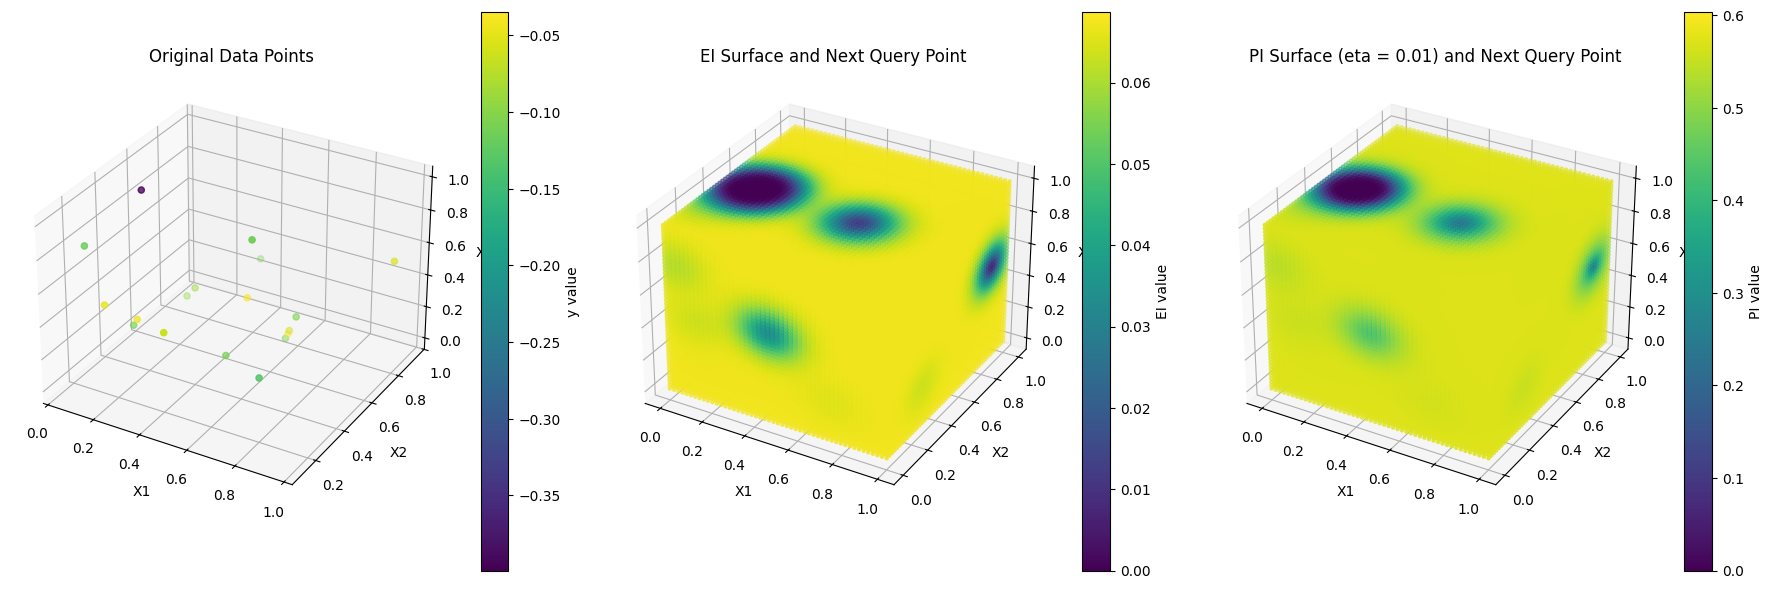

In [19]:
def visualize_gp_ei_pi_3d(X, y, X_viz, ei, pi, next_query_EI, next_query_PI, eta):
    """
    Visualize Gaussian Process results with EI and PI in 3D.
    
    Parameters:
    X (array): Input data points
    y (array): Output values
    X_viz (array): Visualization grid points
    ei (array): Expected Improvement values
    pi (array): Probability of Improvement values
    next_query_EI (array): Next query point based on EI
    next_query_PI (array): Next query point based on PI
    eta (float): Current eta value for PI
    """
    fig = plt.figure(figsize=(18, 6))
    
    # Original data points
    ax1 = fig.add_subplot(131, projection='3d')
    scatter = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
    fig.colorbar(scatter, ax=ax1, label='y value')
    ax1.set_title('Original Data Points')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('X3')
    
    # EI surface
    ax2 = fig.add_subplot(132, projection='3d')
    ei_surface = ax2.scatter(X_viz[:, 0], X_viz[:, 1], X_viz[:, 2], c=ei, cmap='viridis', s=5)
    fig.colorbar(ei_surface, ax=ax2, label='EI value')
    ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c='red', marker='x')
    ax2.scatter(next_query_EI[0], next_query_EI[1], next_query_EI[2], c='white', marker='o', s=100, edgecolor='black')
    ax2.set_title('EI Surface and Next Query Point')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('X3')
    
    # PI surface
    ax3 = fig.add_subplot(133, projection='3d')
    pi_surface = ax3.scatter(X_viz[:, 0], X_viz[:, 1], X_viz[:, 2], c=pi, cmap='viridis', s=5)
    fig.colorbar(pi_surface, ax=ax3, label='PI value')
    ax3.scatter(X[:, 0], X[:, 1], X[:, 2], c='red', marker='x')
    ax3.scatter(next_query_PI[0], next_query_PI[1], next_query_PI[2], c='white', marker='o', s=100, edgecolor='black')
    ax3.set_title(f'PI Surface (eta = {eta}) and Next Query Point')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('X3')
    
    plt.tight_layout()
    plt.show()

eta = 0.01  # You can adjust this value as needed
visualize_gp_ei_pi_3d(X, y, X_viz, ei, pi, next_query_EI, next_query_PI, eta)

In [21]:
function_num = 4
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (30, 4)
Shape of initial y: (30,)
After week 1:
Shape of X: (31, 4)
Shape of y: (31,)
After week 2:
Shape of X: (32, 4)
Shape of y: (32,)
After week 3:
Shape of X: (33, 4)
Shape of y: (33,)

Final DataFrame shape: (33, 5)
          X1        X2        X3        X4          y
0   0.896981  0.725628  0.175404  0.701694 -22.108288
1   0.889356  0.499588  0.539269  0.508783 -14.601397
2   0.250946  0.033693  0.145380  0.494932 -11.699932
3   0.346962  0.006250  0.760564  0.613024 -16.053765
4   0.124871  0.129770  0.384400  0.287076 -10.069633
5   0.801303  0.500231  0.706645  0.195103 -15.487083
6   0.247708  0.060445  0.042186  0.441324 -12.681685
7   0.746702  0.757092  0.369353  0.206566 -16.026400
8   0.400665  0.072574  0.886768  0.243842 -17.049235
9   0.626071  0.586751  0.438806  0.778858 -12.741766
10  0.957135  0.597644  0.766114  0.776210 -27.316396
11  0.732812  0.145250  0.476813  0.133366 -13.527649
12  0.655115  0.072392  0.687152  0.081517 -16.679115
13

In [23]:
# Function to optimize hyperparameters using Optuna
def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.1)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.15)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1.96) #kappa should be

print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=50, start=0, end=1)


# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)

print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)

Optimal hyperparameters (EI): {'l': 747.9954544745591, 'sigma_f': 0.00012466138633693608}
Optimal hyperparameters (PI): {'l': 1.8785392869036917, 'sigma_f': 10325.653313473656}
Optimal hyperparameters (UCB): {'l': 0.0017337728118032392, 'sigma_f': 90.99008930170007}
Next query EI: [0. 0. 0. 0.]
Next query PI: [0.42857143 0.3877551  0.36734694 0.40816327]
Next query UCB: [0. 0. 0. 0.]

Function Number: 4
Next query EI:
[0.000000-0.000000-0.000000-0.000000]
Next query PI:
[0.428571-0.387755-0.367347-0.408163]
Next query UCB:
[0.000000-0.000000-0.000000-0.000000]


In [25]:
function_num = 5
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (20, 4)
Shape of initial y: (20,)
After week 1:
Shape of X: (21, 4)
Shape of y: (21,)
After week 2:
Shape of X: (22, 4)
Shape of y: (22,)
After week 3:
Shape of X: (23, 4)
Shape of y: (23,)

Final DataFrame shape: (23, 5)
          X1        X2        X3        X4            y
0   0.191447  0.038193  0.607418  0.414584    64.443440
1   0.758653  0.536518  0.656000  0.360342    18.301380
2   0.438350  0.804340  0.210245  0.151295     0.112940
3   0.706051  0.534192  0.264243  0.482088     4.210898
4   0.836478  0.193610  0.663893  0.785649   258.370525
5   0.683432  0.118663  0.829046  0.567577    78.434389
6   0.553621  0.667350  0.323806  0.814870    57.571537
7   0.352356  0.322242  0.116979  0.473113   109.571876
8   0.153786  0.729382  0.422598  0.443074     8.847992
9   0.463442  0.630025  0.107906  0.957644   233.223610
10  0.677491  0.358510  0.479592  0.072880    24.423088
11  0.583973  0.147243  0.348097  0.428615    64.420147
12  0.306889  0.316878  0.6226

In [27]:
# Function to optimize hyperparameters using Optuna
def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.1)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.15)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1.96) #kappa should be

print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=50, start=0, end=1)


# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)
print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)

Optimal hyperparameters (EI): {'l': 6.137719839875159e-05, 'sigma_f': 5.563046575068044}
Optimal hyperparameters (PI): {'l': 3.0464064752474167, 'sigma_f': 5.1584973632916125e-05}
Optimal hyperparameters (UCB): {'l': 0.7116369271239941, 'sigma_f': 0.038821095674308755}
Next query EI: [0.2244898  0.85714286 0.91836735 0.87755102]
Next query PI: [0.2244898  0.85714286 0.91836735 0.87755102]
Next query UCB: [0.20408163 0.85714286 0.91836735 0.89795918]

Function Number: 5
Next query EI:
[0.224490-0.857143-0.918367-0.877551]
Next query PI:
[0.224490-0.857143-0.918367-0.877551]
Next query UCB:
[0.204082-0.857143-0.918367-0.897959]


In [32]:
function_num = 6
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (20, 5)
Shape of initial y: (20,)
After week 1:
Shape of X: (21, 5)
Shape of y: (21,)
After week 2:
Shape of X: (22, 5)
Shape of y: (22,)
After week 3:
Shape of X: (23, 5)
Shape of y: (23,)

Final DataFrame shape: (23, 6)
          X1        X2        X3        X4        X5         y
0   0.728186  0.154693  0.732552  0.693997  0.056401 -0.714265
1   0.242384  0.844100  0.577809  0.679021  0.501953 -1.209955
2   0.729523  0.748106  0.679775  0.356552  0.671054 -1.672200
3   0.770620  0.114404  0.046780  0.648324  0.273549 -1.536058
4   0.618812  0.331802  0.187288  0.756238  0.328835 -0.829237
5   0.784958  0.910682  0.708120  0.959225  0.004911 -1.247049
6   0.145111  0.896685  0.896322  0.726272  0.236272 -1.233786
7   0.945069  0.288459  0.978806  0.961656  0.598016 -1.694343
8   0.125720  0.862725  0.028544  0.246605  0.751206 -2.571170
9   0.757594  0.355831  0.016523  0.434207  0.112433 -1.309116
10  0.536797  0.308781  0.411879  0.388225  0.522528 -1.144785
11

In [37]:
# Function to optimize hyperparameters using Optuna
def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=150):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
# Balanced approach
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.05)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.1)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1.96) #kappa should be


print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


#X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=20, start=0, end=1)

initial_point = [0.728186 , 0.154693 ,  0.732552 ,  0.693997 , 0.056401 ]  #new max
#buffer = 0.05
buffer = 0.05
X_viz = create_n_dimensional_meshgrid_v2(initial_point, buffer,num_points=5)
print(f"Shape of X_viz: {X_viz.shape}")
print(f"Range for each dimension:")
for i in range(len(initial_point)):
    print(f"Dimension {i+1}: {X_viz[:, i].min():.2f} to {X_viz[:, i].max():.2f}")
    

# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)
print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)

Optimal hyperparameters (EI): {'l': 0.0044628516279510665, 'sigma_f': 124.35485468914675}
Optimal hyperparameters (PI): {'l': 5.6864596114188234e-05, 'sigma_f': 0.0364382947431713}
Optimal hyperparameters (UCB): {'l': 1.265857988739151e-05, 'sigma_f': 8607.167744570927}
Shape of X_viz: (3125, 5)
Range for each dimension:
Dimension 1: 0.68 to 0.78
Dimension 2: 0.10 to 0.20
Dimension 3: 0.68 to 0.78
Dimension 4: 0.64 to 0.74
Dimension 5: 0.01 to 0.11
Next query EI: [0.678186 0.204693 0.782552 0.743997 0.006401]
Next query PI: [0.678186 0.204693 0.782552 0.743997 0.006401]
Next query UCB: [0.678186 0.204693 0.782552 0.743997 0.006401]

Function Number: 6
Next query EI:
[0.678186-0.204693-0.782552-0.743997-0.006401]
Next query PI:
[0.678186-0.204693-0.782552-0.743997-0.006401]
Next query UCB:
[0.678186-0.204693-0.782552-0.743997-0.006401]


In [33]:
#manual

optimal_params_ei = {'l': 1.0, 'sigma_f': 1.0}
optimal_params_pi = {'l': 1.0, 'sigma_f': 1.0}
optimal_params_ucb = {'l': 1.0, 'sigma_f': 1.0}

print("Fixed hyperparameters (EI):", optimal_params_ei)
print("Fixed hyperparameters (PI):", optimal_params_pi)
print("Fixed hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


#X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=20, start=0, end=1)
initial_point = [0.728186 , 0.154693 ,  0.732552 ,  0.693997 , 0.056401 ]  #new max
#buffer = 0.05
buffer = 0.05
X_viz = create_n_dimensional_meshgrid_v2(initial_point, buffer,num_points=5)


# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)
print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)




Fixed hyperparameters (EI): {'l': 1.0, 'sigma_f': 1.0}
Fixed hyperparameters (PI): {'l': 1.0, 'sigma_f': 1.0}
Fixed hyperparameters (UCB): {'l': 1.0, 'sigma_f': 1.0}
Next query EI: [0. 0. 0. 0. 0.]
Next query PI: [0. 0. 0. 0. 0.]
Next query UCB: [0. 0. 0. 0. 0.]

Function Number: 6
Next query EI:
[0.000000-0.000000-0.000000-0.000000-0.000000]
Next query PI:
[0.000000-0.000000-0.000000-0.000000-0.000000]
Next query UCB:
[0.000000-0.000000-0.000000-0.000000-0.000000]


In [39]:
function_num = 7
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (30, 6)
Shape of initial y: (30,)
After week 1:
Shape of X: (31, 6)
Shape of y: (31,)
After week 2:
Shape of X: (32, 6)
Shape of y: (32,)
After week 3:
Shape of X: (33, 6)
Shape of y: (33,)

Final DataFrame shape: (33, 7)
          X1        X2        X3        X4        X5        X6         y
0   0.272624  0.324495  0.897109  0.832951  0.154063  0.795864  0.604433
1   0.543003  0.924694  0.341567  0.646486  0.718440  0.343133  0.562753
2   0.090832  0.661529  0.065931  0.258577  0.963453  0.640265  0.007503
3   0.118867  0.615055  0.905816  0.855300  0.413631  0.585236  0.061424
4   0.630218  0.838097  0.680013  0.731895  0.526737  0.348429  0.273047
5   0.764919  0.255883  0.609084  0.218079  0.322943  0.095794  0.083747
6   0.057896  0.491672  0.247422  0.218118  0.420428  0.730970  1.364968
7   0.195252  0.079227  0.554580  0.170567  0.014944  0.107032  0.092645
8   0.642303  0.836875  0.021793  0.101488  0.683071  0.692416  0.017870
9   0.789943  0.195545  0.57

In [41]:
# Function to optimize hyperparameters using Optuna
def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=75):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.1)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.15)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1.96) #kappa should be

print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=10, start=0, end=1)


# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)
print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)

Optimal hyperparameters (EI): {'l': 0.13760260908262295, 'sigma_f': 379.4269413497454}
Optimal hyperparameters (PI): {'l': 0.04670827155867807, 'sigma_f': 0.09927262095095121}
Optimal hyperparameters (UCB): {'l': 0.03238333919060762, 'sigma_f': 23.88084909818598}
Next query EI: [0.         0.33333333 0.33333333 0.11111111 0.33333333 0.66666667]
Next query PI: [0.         0.33333333 0.33333333 0.11111111 0.33333333 0.66666667]
Next query UCB: [0.         0.33333333 0.33333333 0.11111111 0.33333333 0.55555556]

Function Number: 7
Next query EI:
[0.000000-0.333333-0.333333-0.111111-0.333333-0.666667]
Next query PI:
[0.000000-0.333333-0.333333-0.111111-0.333333-0.666667]
Next query UCB:
[0.000000-0.333333-0.333333-0.111111-0.333333-0.555556]


In [43]:
function_num = 8
num_week = 3

X, y, df, max_y, max_row = load_and_process_data(function_num, num_week)

Shape of initial X: (40, 8)
Shape of initial y: (40,)
After week 1:
Shape of X: (41, 8)
Shape of y: (41,)
After week 2:
Shape of X: (42, 8)
Shape of y: (42,)
After week 3:
Shape of X: (43, 8)
Shape of y: (43,)

Final DataFrame shape: (43, 9)
          X1        X2        X3        X4        X5        X6        X7  \
0   0.604994  0.292215  0.908453  0.355506  0.201669  0.575338  0.310311   
1   0.178007  0.566223  0.994862  0.210325  0.320153  0.707909  0.635384   
2   0.009077  0.811626  0.520520  0.075687  0.265112  0.091652  0.592415   
3   0.506028  0.653730  0.363411  0.177981  0.093728  0.197425  0.755827   
4   0.359909  0.249076  0.495997  0.709215  0.114987  0.289207  0.557295   
5   0.778818  0.003419  0.337983  0.519528  0.820907  0.537247  0.551347   
6   0.908649  0.062250  0.238260  0.766604  0.132336  0.990244  0.688068   
7   0.586371  0.880736  0.745021  0.546035  0.009649  0.748992  0.230907   
8   0.761137  0.854672  0.382124  0.337352  0.689708  0.309853  0.631380  

In [47]:

def optimize_hyperparameters(X, y, acquisition_func, xi, n_trials=75):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, acquisition_func, xi), n_trials=n_trials)
    
    return study.best_params

# Optimize hyperparameters using EI, PI, and UCB
optimal_params_ei = optimize_hyperparameters(X, y, 'EI', xi=0.1)
optimal_params_pi = optimize_hyperparameters(X, y, 'PI', xi=0.15)
optimal_params_ucb = optimize_hyperparameters(X, y, 'UCB', xi=1.96) #kappa should be

print("Optimal hyperparameters (EI):", optimal_params_ei)
print("Optimal hyperparameters (PI):", optimal_params_pi)
print("Optimal hyperparameters (UCB):", optimal_params_ucb)

# Create and fit GPR models with optimized hyperparameters
def create_gpr(params):
    kernel = C(params['sigma_f']**2) * RBF(params['l'])
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
    gpr.fit(X, y)
    return gpr

gpr_ei = create_gpr(optimal_params_ei)
gpr_pi = create_gpr(optimal_params_pi)
gpr_ucb = create_gpr(optimal_params_ucb)


#X_viz = create_n_dimensional_meshgrid(n_dimensions=X.shape[1], num_points=10, start=0, end=1)
#initial_point = [0.056447 , 0.065956 , 0.022929 , 0.038786 , 0.403935 , 0.801055 , 0.488307  , 0.8930854]  # Example initial point
initial_point = [0.006447 ,  0.015956  , 0.0  ,   0.0 ,     0.353935 ,  0.751055 , 0.438307 , 0.843085]  #new max
initial_point = [0.0 , 0.0 , 0.0 , 0.0 , 0.303935 , 0.701055 , 0.388307 , 0.793085]  #new max
buffer = 0.05
#buffer = 0.1
X_viz = create_n_dimensional_meshgrid_v2(initial_point, buffer,num_points=5)
print(f"Shape of X_viz: {X_viz.shape}")
print(f"Range for each dimension:")
for i in range(len(initial_point)):
    print(f"Dimension {i+1}: {X_viz[:, i].min():.2f} to {X_viz[:, i].max():.2f}")

# Calculate acquisition functions
ei = expected_improvement(X_viz, X, y, gpr_ei)
pi = probability_of_improvement(X_viz, X, y, gpr_pi)
ucb = upper_confidence_bound(X_viz, X, y, gpr_ucb)

# Find the next query points
next_query_EI = X_viz[np.argmax(ei)]
next_query_PI = X_viz[np.argmax(pi)]
next_query_UCB = X_viz[np.argmax(ucb)]

print('Next query EI:', next_query_EI)
print('Next query PI:', next_query_PI)
print('Next query UCB:', next_query_UCB)
print('\nFunction Number:',function_num)
format_results('Next query EI:', next_query_EI)
format_results('Next query PI:', next_query_PI)
format_results('Next query UCB:', next_query_UCB)


Optimal hyperparameters (EI): {'l': 0.0525854916760838, 'sigma_f': 29.017772561908064}
Optimal hyperparameters (PI): {'l': 7.296315729788057e-05, 'sigma_f': 0.03952298339745071}
Optimal hyperparameters (UCB): {'l': 6.762022325765186e-05, 'sigma_f': 0.7137212720205187}
Shape of X_viz: (390625, 8)
Range for each dimension:
Dimension 1: 0.00 to 0.05
Dimension 2: 0.00 to 0.05
Dimension 3: 0.00 to 0.05
Dimension 4: 0.00 to 0.05
Dimension 5: 0.25 to 0.35
Dimension 6: 0.65 to 0.75
Dimension 7: 0.34 to 0.44
Dimension 8: 0.74 to 0.84
Next query EI: [0.05     0.05     0.05     0.05     0.353935 0.651055 0.338307 0.743085]
Next query PI: [0.       0.       0.       0.       0.253935 0.651055 0.338307 0.743085]
Next query UCB: [0.       0.       0.       0.       0.253935 0.651055 0.338307 0.743085]

Function Number: 8
Next query EI:
[0.050000-0.050000-0.050000-0.050000-0.353935-0.651055-0.338307-0.743085]
Next query PI:
[0.000000-0.000000-0.000000-0.000000-0.253935-0.651055-0.338307-0.743085]
Nex